## TensorFlow自动求导和梯度下降原理

本文以华氏温度转换为摄氏温度（一元线性回归模型）为例子，讲解了深度学习框架（TensorFlow）自动求导和梯度下降的原理。文章内容分为三节，层层递进，分别是：
1. 手动反向传播求导、手动梯度下降
2. 自动求导，手动梯度下降
3. 自动求导，自动梯度下降

In [ ]:
%matplotlib inline
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
# 数据
Y = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0] # 摄氏度 Celsius
X = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # 华氏度 Fahrenheit

In [5]:
# 转化成张量
Y = tf.constant(Y)
X = tf.constant(X)
X, Y

(<tf.Tensor: shape=(11,), dtype=float32, numpy=
 array([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4],
       dtype=float32)>, <tf.Tensor: shape=(11,), dtype=float32, numpy=
 array([ 0.5, 14. , 15. , 28. , 11. ,  8. ,  3. , -4. ,  6. , 13. , 21. ],
       dtype=float32)>)

模型与损失函数。这里使用最简单的一元线性回归模型和均方根损失函数

In [6]:
def model(X, w, b):
    return w * X + b

In [11]:
def loss_fn(Y_hat, Y):
    squared_diffs = (Y_hat - Y)**2
    return tf.reduce_mean(squared_diffs)

### 动反向传播求导、手动梯度下降

In [8]:
# 模型参数
w = tf.ones(1)
b = tf.zeros(1)

In [9]:
# 模型预测输出
Y_hat = model(X, w, b)
Y_hat

<tf.Tensor: shape=(11,), dtype=float32, numpy=
array([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4],
      dtype=float32)>

In [12]:
# 模型损失
loss = loss_fn(Y_hat, Y)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=1763.8848>

### 手动反向传播求导

In [13]:
def dloss_fn(Y_hat, Y):
    dsq_diffs = 2 * (Y_hat - Y)
    return dsq_diffs

In [14]:
def dmodel_dw(X, w, b):
    return X

In [15]:
def dmodel_db(X, w, b):
    return 1.0

In [16]:
def grad_fn(X, Y, Y_hat, w, b):
    dloss_dw = dloss_fn(Y_hat, Y) * dmodel_dw(X, w, b)
    dloss_db = dloss_fn(Y_hat, Y) * dmodel_db(X, w, b)
    return tf.stack([tf.reduce_mean(dloss_dw), tf.reduce_mean(dloss_db)])

In [17]:
def training_loop(n_epochs, learning_rate, params, X, Y, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        Y_hat = model(X, w, b)  # <1>
        loss = loss_fn(Y_hat, Y)
        grad = grad_fn(X, Y, Y_hat, w, b)  # <2>

        params = params - learning_rate * grad # 手动梯度下降

        if epoch % 30000 == 0:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)

        if tf.math.is_inf(loss):
            break  # <3>
            
    return params

In [18]:
params = training_loop(
    n_epochs = 330000, 
    learning_rate = 1e-4, 
    params = tf.constant([1.00, 0.01]), 
    X = X, 
    Y = Y,
    print_params = False)

params

Epoch 30000, Loss 12.095908
Epoch 60000, Loss 6.133891
Epoch 90000, Loss 4.048903
Epoch 120000, Loss 3.319792
Epoch 150000, Loss 3.064586
Epoch 180000, Loss 2.975681
Epoch 210000, Loss 2.944574
Epoch 240000, Loss 2.933552
Epoch 270000, Loss 2.929731
Epoch 300000, Loss 2.928472
Epoch 330000, Loss 2.927906


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([  0.5358124, -17.250313 ], dtype=float32)>

In [19]:
# 模型预测。根据训练后的参数进行模型预测。
Y_hat = model(X, *params)

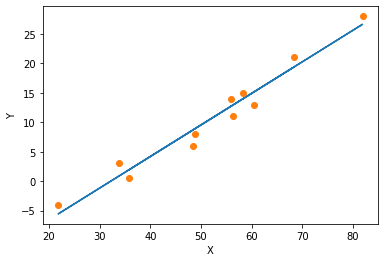

In [23]:
# 比较预测结果（直线）与标准答案（圆点）
fig = plt.figure()
plt.xlabel("X")
plt.ylabel("Y")
plt.plot(X.numpy(), Y_hat.numpy()) # <2>
plt.plot(X.numpy(), Y.numpy(), 'o')

### 自动求导，手动梯度下降

In [24]:
# 定义模型参数
params = tf.constant([1.00, 0.01])

In [25]:
# 定义模型损失函数
loss_object = tf.keras.losses.MeanSquaredError()

In [26]:
with tf.GradientTape() as tape:
    tape.watch(params) # 指定要求导的对象
    Y_hat = model(X, *params)
    loss = loss_object(Y_hat, Y) 

In [27]:
# 自动反向传播求导
gradients = tape.gradient(loss, params)

In [28]:
# 查看导数值
gradients

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4518.333,   82.62 ], dtype=float32)>

In [29]:
def training_loop(n_epochs, learning_rate, params, X, Y):
    for epoch in range(1, n_epochs + 1):
        with tf.GradientTape() as tape:
            tape.watch(params)
            Y_hat = model(X, *params)
            loss = loss_object(Y_hat, Y) 
        gradients = tape.gradient(loss, params)
        params = params - learning_rate * gradients
        if epoch % 30000 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [30]:
training_loop(
    n_epochs = 330000, 
    learning_rate = 1e-4, 
    params = tf.constant([1.00, 0.01]),
    X = X,
    Y = Y)

Epoch 30000, Loss 12.095908
Epoch 60000, Loss 6.133891
Epoch 90000, Loss 4.048903
Epoch 120000, Loss 3.319792
Epoch 150000, Loss 3.064586
Epoch 180000, Loss 2.975681
Epoch 210000, Loss 2.944574
Epoch 240000, Loss 2.933552
Epoch 270000, Loss 2.929731
Epoch 300000, Loss 2.928472
Epoch 330000, Loss 2.927906


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([  0.5358124, -17.250313 ], dtype=float32)>

### 自动求导，自动梯度下降

In [31]:
def model(X, params):
    return params[0] * X + params[1]

In [32]:
def loss_fn(Y_hat, Y):
    squared_diffs = (Y_hat - Y)**2
    return tf.reduce_mean(squared_diffs)

In [33]:
# 定义模型参数、损失函数、优化器
params = tf.Variable([1.00, 0.01])
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)

In [34]:
with tf.GradientTape() as tape:
    tape.watch(params)
    Y_hat = model(X, params)
    loss = loss_object(Y_hat, Y) 

In [35]:
# 自动反向传播求导
gradients = tape.gradient(loss, params)

In [36]:
# 查看导数值
gradients

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4518.333,   82.62 ], dtype=float32)>

In [37]:
# 查看参数值
params

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1.  , 0.01], dtype=float32)>

In [38]:
# 自动梯度下降
optimizer.apply_gradients(zip([gradients], [params]))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [39]:
# 查看自动梯度下降后的参数值
params

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.54816675, 0.001738  ], dtype=float32)>

In [40]:
def training_loop(n_epochs, params, X, Y):
    for epoch in range(1, n_epochs + 1):
        with tf.GradientTape() as tape:
            tape.watch(params)
            Y_hat = model(X, params)
            loss = loss_object(Y_hat, Y) 
        gradients = tape.gradient(loss, params)
        optimizer.apply_gradients(zip([gradients], [params]))
        if epoch % 30000 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [41]:
training_loop(
    n_epochs = 330000, 
    params = tf.Variable([1.00, 0.01]),
    X = X,
    Y = Y)

Epoch 30000, Loss 12.095908
Epoch 60000, Loss 6.133891
Epoch 90000, Loss 4.048903
Epoch 120000, Loss 3.319792
Epoch 150000, Loss 3.064586
Epoch 180000, Loss 2.975681
Epoch 210000, Loss 2.944574
Epoch 240000, Loss 2.933552
Epoch 270000, Loss 2.929731
Epoch 300000, Loss 2.928472
Epoch 330000, Loss 2.927906


<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([  0.5358124, -17.250313 ], dtype=float32)>